In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error

def df_preview(df):
    for col in df.columns:
        print(col, "null count ::", df[col].isnull().sum(), "// mean ::", df[col].mean())

def df_col_distplot(df):
    for col in df.columns:
        print(col, "plot")
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()

def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

In [2]:
## concat_df: train, test 를 합친 dataframe

concat_df = pd.concat([train, test])
concat_df.shape

## feature_df: target 을 제외한 dataframe

target_cols = ['hhb', 'hbo2', 'ca', 'na']
feature_df = concat_df.drop(target_cols, axis=1)

In [3]:
feature_dst = feature_df.filter(regex='_dst$', axis=1)

In [4]:
## KNNImputer 를 사용함

from sklearn.impute import KNNImputer

imputer_n10 = KNNImputer(n_neighbors=10)
imputer_n30 = KNNImputer(n_neighbors=30)
imputer_n50 = KNNImputer(n_neighbors=50)

In [5]:
imputed_10_df = imputer_n10.fit_transform(feature_dst)
imputed_30_df = imputer_n30.fit_transform(feature_dst)
imputed_50_df = imputer_n50.fit_transform(feature_dst)

## impute 결과가 list 로 나오기 때문에 dataframe 으로 바꿔주는 작업
imputed_10_df = pd.DataFrame(imputed_10_df, columns=feature_dst.columns, index=list(feature_dst.index.values))
imputed_30_df = pd.DataFrame(imputed_30_df, columns=feature_dst.columns, index=list(feature_dst.index.values))
imputed_50_df = pd.DataFrame(imputed_50_df, columns=feature_dst.columns, index=list(feature_dst.index.values))

In [6]:
target_cols = ['hhb', 'hbo2', 'ca', 'na']

for col_name in target_cols:
    imputed_10_df[col_name] = concat_df[col_name]
    imputed_30_df[col_name] = concat_df[col_name]
    imputed_50_df[col_name] = concat_df[col_name]

imputed_train_10 = imputed_10_df[imputed_10_df['hhb'].notnull()]
imputed_train_30 = imputed_30_df[imputed_30_df['hhb'].notnull()]
imputed_train_50 = imputed_50_df[imputed_50_df['hhb'].notnull()]
imputed_test_10 = imputed_10_df[imputed_10_df['hhb'].isnull()]
imputed_test_30 = imputed_30_df[imputed_30_df['hhb'].isnull()]
imputed_test_50 = imputed_50_df[imputed_50_df['hhb'].isnull()]

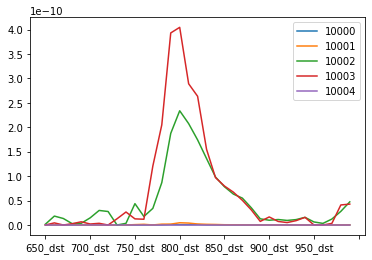

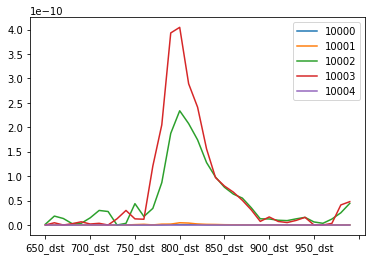

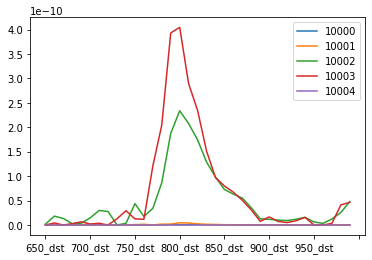

In [7]:
imputed_test_10.filter(regex='_dst$', axis=1).head().T.plot()
imputed_test_30.filter(regex='_dst$', axis=1).head().T.plot()
imputed_test_50.filter(regex='_dst$', axis=1).head().T.plot()

In [8]:
feature_df.update(imputed_30_df)
feature_df

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,
0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,...,9.727870e-19,3.527371e-18,1.130983e-18,6.455564e-19,9.663751e-19,0.000000e+00,7.425205e-19,1.067504e-18,5.998949e-18,4.378513e-17
1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,...,2.647633e-09,1.682896e-10,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,2.799156e-10,9.710091e-09,9.192786e-11
2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,...,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,1.290044e-17
3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,...,1.274876e-10,6.118947e-11,9.433465e-11,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,7.685807e-11,4.088921e-10,3.029613e-10
4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,...,0.000000e+00,2.555342e-14,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,2.004864e-14,1.330237e-13,2.683695e-13,1.069513e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,15,0.04334,0.03279,0.05853,0.04070,0.07704,0.07859,0.06168,0.08903,0.08833,...,7.889599e-13,5.487817e-13,4.903209e-13,1.365078e-12,7.929664e-13,0.000000e+00,0.000000e+00,1.472213e-13,1.479745e-12,5.391520e-12
19996,25,0.00020,0.02009,0.01726,0.03816,0.08300,0.08681,0.15300,0.18099,0.24377,...,1.240848e-17,6.258180e-18,8.693704e-20,1.259932e-18,4.514449e-18,5.133327e-19,9.128300e-19,5.952527e-19,3.928314e-18,2.586781e-17
19997,15,0.00000,0.00000,0.00120,0.00000,0.04347,0.14882,0.40883,0.80365,1.01179,...,0.000000e+00,2.078241e-15,0.000000e+00,2.610282e-14,7.789652e-15,7.917686e-16,1.271388e-15,1.436617e-15,0.000000e+00,1.743751e-13


In [9]:
target_cols = ['hhb', 'hbo2', 'ca', 'na']

for col_name in target_cols:
    feature_df[col_name] = concat_df[col_name]

feature_train = feature_df[feature_df['hhb'].notnull()]
feature_test = feature_df[feature_df['hhb'].isnull()]

In [10]:
dont_need_scale_cols = ['rho', 'hhb', 'hbo2', 'ca', 'na']
droped_df = feature_df.drop(dont_need_scale_cols, axis=1)

In [11]:
std_scaler = StandardScaler()
std_scaler.fit(droped_df)
scaled_feature = std_scaler.transform(droped_df)
scaled_feature = pd.DataFrame(scaled_feature, columns=droped_df.columns, index=list(droped_df.index.values))

In [12]:
for col_name in dont_need_scale_cols:
    scaled_feature[col_name] = concat_df[col_name]

scaled_train = scaled_feature[scaled_feature['hhb'].notnull()]
scaled_test = scaled_feature[scaled_feature['hhb'].isnull()]

In [13]:
from sklearn.model_selection import KFold
fold_num = 10
folds = KFold(n_splits = fold_num, shuffle = True, random_state = 551)

In [14]:
import lightgbm as lgb

feature_col = scaled_train.columns.drop(['hhb', 'hbo2', 'ca', 'na'])
target_col_list = ['hhb', 'hbo2', 'ca', 'na']
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

submission_stack_df = pd.read_csv('../data/sample_submission.csv', index_col='id')
train_stack_df = pd.DataFrame(index=list(scaled_train[feature_col].index.values))

train_check_df = pd.DataFrame(columns=target_col_list, index=list(scaled_train[feature_col].index.values))
train_check_df = train_check_df.fillna(0)

for target_col in target_col_list:
    print("target_col :: ",target_col)
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(scaled_train)):
        x_data = scaled_train[feature_col]
        y_data = scaled_train[target_col]

        train_X, train_y = x_data.iloc[trn_idx], y_data.iloc[trn_idx] 
        valid_X, valid_y = x_data.iloc[val_idx], y_data.iloc[val_idx]

        train_ds = lgb.Dataset(train_X, label=train_y)
        valid_ds = lgb.Dataset(valid_X, label=valid_y)

        params = {
            'objective':'regression', 
            'n_estimators': 10000,
            'metric': 'regression_l1',
            'boosting': 'dart',
            'learning_rate': 0.1
        }

        model = lgb.train(
            params=params, 
            train_set=train_ds, 
            valid_sets=valid_ds, 
            verbose_eval=10000, 
            early_stopping_rounds=20 
        )

        test_x = scaled_test[feature_col]
        test_pred = model.predict(test_x)

        train_check_pred = model.predict(x_data)


        submission[target_col] = submission[target_col] + test_pred
        train_check_df[target_col] = train_check_df[target_col] + train_check_pred

        submission_stack_df[target_col+"_"+str(n_fold)] = test_pred
        train_stack_df[target_col+"_"+str(n_fold)] = train_check_pred

target_col ::  hhb
[10000]	valid_0's l1: 0.796814
[10000]	valid_0's l1: 0.787774
[10000]	valid_0's l1: 0.78126
[10000]	valid_0's l1: 0.810363
[10000]	valid_0's l1: 0.822151
[10000]	valid_0's l1: 0.790541
[10000]	valid_0's l1: 0.767193
[10000]	valid_0's l1: 0.781977
[10000]	valid_0's l1: 0.787282
[10000]	valid_0's l1: 0.794131
target_col ::  hbo2
[10000]	valid_0's l1: 0.603383
[10000]	valid_0's l1: 0.621913
[10000]	valid_0's l1: 0.615342
[10000]	valid_0's l1: 0.608541
[10000]	valid_0's l1: 0.61472
[10000]	valid_0's l1: 0.586228
[10000]	valid_0's l1: 0.604917
[10000]	valid_0's l1: 0.582947
[10000]	valid_0's l1: 0.598745
[10000]	valid_0's l1: 0.615981
target_col ::  ca
[10000]	valid_0's l1: 1.78766
[10000]	valid_0's l1: 1.83703
[10000]	valid_0's l1: 1.86835
[10000]	valid_0's l1: 1.9005
[10000]	valid_0's l1: 1.83776
[10000]	valid_0's l1: 1.78816
[10000]	valid_0's l1: 1.92627
[10000]	valid_0's l1: 1.79575
[10000]	valid_0's l1: 1.80238
[10000]	valid_0's l1: 1.7153
target_col ::  na
[10000]	v

In [15]:
save_train_check_df = train_check_df
save_submission = submission

train_check_df_output = train_check_df / fold_num
submission_output = submission / fold_num

In [16]:
# train_check_df_output
submission_output

,hhb,hbo2,ca,na
id,,,,
10000,8.803928,4.651166,9.323272,3.706325
10001,6.857897,3.360361,8.763513,2.996571
10002,9.630665,5.341324,9.975254,4.237020
10003,8.618729,3.810162,10.809085,3.667204
10004,6.388203,3.477083,8.017156,4.260402
...,...,...,...,...
19995,4.428551,3.969100,12.398756,3.514687
19996,11.081788,3.216758,7.148760,2.146363
19997,8.039785,3.720790,7.832987,4.004741


In [17]:
## kfold = 5 일때 0.7894323554908189
## kfold = 10 일때 0.7250456556277579 제출점수 : 1.1461927611
## kfold = 30 일때 0.7963150613320916 제출점수 : 1.1488628449

## kfold = 10, lgbm 'metric': 'regression_l1' 일때 0.6777813130969296
## kfold = 10, lgbm 'metric': 'regression_l1', 'boosting': 'dart' 일때 0.5933223352694381 제출점수: 1.12831
## kfold = 10, lgbm 'metric': 'regression_l1', 'boosting': 'dart' 'n_estimators': 10000 일때 ? 제출점수: 1.11152

## imputer_n50, kfold = 10, lgbm 'metric': 'regression_l1' 일때 0.6784851435783203
## imputer_n30, kfold = 10, lgbm 'metric': 'regression_l1' 일때 0.6623768396235288
## imputer_n30, kfold = 10, lgbm 'metric': 'regression_l1' 일때 0.592308596609843

target_col_list = ['hhb', 'hbo2', 'ca', 'na']

res = rmse(train_check_df_output, scaled_train[target_col_list])
res

0.2298901409538472

In [28]:
submission_stack_df
# train_stack_df

,hhb,hbo2,ca,na,hhb_0,hhb_1,hhb_2,hhb_3,hhb_4,hhb_5,...,na_0,na_1,na_2,na_3,na_4,na_5,na_6,na_7,na_8,na_9
id,,,,,,,,,,,,,,,,,,,,,
10000,0,0,0,0,8.858666,8.808111,8.858181,8.728463,8.965395,8.663904,...,4.037911,3.430020,4.059771,4.170154,3.686642,3.550135,3.341518,3.675558,3.479693,3.631853
10001,0,0,0,0,6.826276,7.046209,7.068053,6.715058,6.608733,6.927161,...,2.896583,3.164791,3.099918,3.170942,2.790104,2.717926,2.820382,3.132227,3.362003,2.810839
10002,0,0,0,0,9.495872,9.692859,9.933376,9.714318,9.541029,9.823628,...,4.599364,3.789957,4.117693,4.648849,3.913850,4.144031,4.212899,4.378023,4.284108,4.281425
10003,0,0,0,0,8.626941,8.789603,8.670997,8.840175,8.636538,8.464621,...,3.985638,3.654954,3.766871,3.817578,3.663534,3.718369,3.412810,3.472968,3.846185,3.333134
10004,0,0,0,0,6.086277,6.619238,6.396089,6.156586,6.637829,6.727463,...,4.430503,4.018823,4.010419,3.755188,4.792324,4.493377,4.391511,4.559218,4.213652,3.939008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,4.444612,4.765923,4.259419,4.323306,4.484310,4.272029,...,3.295900,3.506207,3.678406,3.409475,3.331724,3.610229,3.727589,3.543427,3.456480,3.587430
19996,0,0,0,0,10.934255,10.975384,11.174409,10.975189,10.794132,11.053061,...,2.099874,1.839316,2.295244,2.088915,1.760243,2.893261,2.176506,1.847306,2.285785,2.177185
19997,0,0,0,0,7.934567,8.767783,7.723599,7.936304,8.052094,8.129295,...,4.236006,3.515553,4.040930,4.387201,3.727702,4.188407,3.940793,3.733246,3.928208,4.349362


In [19]:
from sklearn.linear_model import Lasso

target_col_list = ['hhb', 'hbo2', 'ca', 'na']
train_stack_df_output = pd.DataFrame(index=list(scaled_train[feature_col].index.values))

for target_col in target_col_list:
    x_data = train_stack_df.filter(regex=target_col, axis=1)
    y_data = scaled_train[target_col]

    meta_model_lasso = Lasso(alpha=0.0005)
    meta_model_lasso.fit(x_data, y_data) 

    train_check_pred = meta_model_lasso.predict(x_data)
    train_stack_df_output[target_col] = train_check_pred

    submission_test_data = submission_stack_df.filter(regex=target_col+'_', axis=1)
    submission[target_col] = meta_model_lasso.predict(submission_test_data)

train_res = rmse(train_stack_df_output, scaled_train[target_col_list])
print(train_res)
print(submission)

0.1523281325652028
             hhb      hbo2         ca        na
id                                             
10000   8.828789  4.717541   9.362227  3.779399
10001   6.847588  3.301289   8.751907  2.998353
10002   9.688608  5.476720  10.079768  4.372871
10003   8.652905  3.794044  10.996003  3.739570
10004   6.366265  3.430154   7.937511  4.401534
...          ...       ...        ...       ...
19995   4.353373  3.969253  12.723327  3.571613
19996  11.157190  3.143491   6.976335  2.046531
19997   8.058807  3.695133   7.744311  4.110848
19998  12.948605  4.567711   9.370691  3.412033
19999   4.684902  4.991672  10.884265  2.247789

[10000 rows x 4 columns]


In [27]:
# submission_stack_df
# train_stack_df
# train_stack_df_output

# kfold 를 lasso 로 학습해서 구한거 submission 
# kfold 더해서 나눈거 submission_output

,hhb,hbo2,ca,na
id,,,,
10000,8.803928,4.651166,9.323272,3.706325
10001,6.857897,3.360361,8.763513,2.996571
10002,9.630665,5.341324,9.975254,4.237020
10003,8.618729,3.810162,10.809085,3.667204
10004,6.388203,3.477083,8.017156,4.260402
...,...,...,...,...
19995,4.428551,3.969100,12.398756,3.514687
19996,11.081788,3.216758,7.148760,2.146363
19997,8.039785,3.720790,7.832987,4.004741


In [22]:
target_col_list = ['hhb', 'hbo2', 'ca', 'na']

res = rmse(train_check_df_output, scaled_train[target_col_list])
res

0.2298901409538472

In [29]:
import time
filename = time.strftime('%Y-%m-%d-%H_%M_%S')+'submission.csv'

train_stack_df.to_csv('train_stack_df.csv', index=True)
train_stack_df_output.to_csv('train_stack_df_output.csv', index=True)
submission.to_csv('submission.csv', index=True)
submission_stack_df.to_csv('submission_stack_df.csv', index=True)
submission_output.to_csv('submission_output.csv', index=True)

